# Tilt-Shift Effect

In [1]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download our images
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images_tilt.zip
!unzip -qq images_tilt.zip
!find . -name ".DS_Store" -delete
!find . -name ".ipynb_checkpoints" -delete

--2022-09-20 17:28:13--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/images_tilt.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.150.194
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.150.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1242115 (1.2M) [application/zip]
Saving to: ‘images_tilt.zip’

images_tilt.zip     100%[===================>]   1.18M  1.46MB/s    in 0.8s    

2022-09-20 17:28:15 (1.46 MB/s) - ‘images_tilt.zip’ saved [1242115/1242115]



#### Function to implement Tilt Shift Effect

In [2]:
#!/usr/bin/python
"""Script to blend two images."""
import cv2
import math
import os
import numpy as np
import scipy.signal
import shutil


def generating_kernel(parameter):
    """ Return a 5x5 generating kernel based on an input parameter.

    Note: This function is provided for you, do not change it.

    Args:
    parameter (float): Range of value: [0, 1].

    Returns:
    numpy.ndarray: A 5x5 kernel.

    """
    kernel = np.array([0.25 - parameter / 2.0, 0.25, parameter,
                       0.25, 0.25 - parameter / 2.0])
    return np.outer(kernel, kernel)


def reduce_img(image):
    """ Convolve the input image with a generating kernel of parameter of 0.4
    and then reduce its width and height by two.

    You can use any / all functions to convolve and reduce the image, although
    the lectures have recommended methods that we advise since there are a lot
    of pieces to this assignment that need to work 'just right'.

    Args:
    image (numpy.ndarray): a grayscale image of shape (r, c)

    Returns:
    output (numpy.ndarray): an image of shape (ceil(r/2), ceil(c/2))
      For instance, if the input is 5x7, the output will be 3x4.

    """
    # per the instructions, use 0.4 for the kernel generation
    kernel = generating_kernel(0.4)

    # use convolve2d with the image and kernel sent in
    output = scipy.signal.convolve2d(image, kernel, 'same')

    # return every other line and row
    return output[:output.shape[0]:2, :output.shape[1]:2]


def expand(image):
    """ Expand the image to double the size and then convolve it with a
    generating kernel with a parameter of 0.4.

    You should upsample the image, and then convolve it with a generating
    kernel of a = 0.4.

    Finally, multiply your output image by a factor of 4 in order to scale it
    back up. If you do not do this (and I recommend you try it out without
    that) you will see that your images darken as you apply the convolution.
    Please explain why this happens in your submission PDF.

    Please consult the lectures and readme for a more in-depth discussion of
    how to tackle the expand function.

    You can use any / all functions to convolve and reduce the image, although
    the lectures have recommended methods that we advise since there are a lot
    of pieces to this assignment that need to work 'just right'.

    Args:
    image (numpy.ndarray): a grayscale image of shape (r, c)

    Returns:
    output (numpy.ndarray): an image of shape (2*r, 2*c)
    """
    # per the instructions, use 0.4 for the kernel generation
    kernel = generating_kernel(0.4)

    # make a new array double the size, assign initial values
    output = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
    output[:output.shape[0]:2, :output.shape[1]:2] = image

    # use convolve2d to fill in rest
    # multiply by 4 per instructions to scale back up
    output = scipy.signal.convolve2d(output, kernel, 'same') * 4
    return output


def gauss_pyramid(image, levels):
    """ Construct a pyramid from the image by reducing it by the number of
    levels passed in by the input.

    Note: You need to use your reduce function in this function to generate the
    output.

    Args:
      image (numpy.ndarray): A grayscale image of dimension (r,c) and dtype
      float.
      levels (uint8): A positive integer that specifies the number of
                    reductions you should do. So, if levels = 0, you should
                    return a list containing just the input image. If
                    levels = 1, you should do one reduction.
                    len(output) = levels + 1

    Returns:
      output (list): A list of arrays of dtype np.float. The first element of
                the list (output[0]) is layer 0 of the pyramid (the image
                itself). output[1] is layer 1 of the pyramid (image reduced
                once), etc. We have already included the original image in
                the output array for you. The arrays are of type numpy.ndarray.

    Consult the lecture and README for more details about Gaussian Pyramids.
    """
    output = [image]
    for level in range(levels):
        output.append(reduce_img(output[level]))

    return output


def lapl_pyramid(gauss_pyr):
    """ Construct a Laplacian pyramid from the Gaussian pyramid, of height
    levels.

    Note: You must use your expand function in this function to generate the
    output. The Gaussian Pyramid that is passed in is the output of your
    gauss_pyramid function.

    Args:
      gauss_pyr (list): A Gaussian Pyramid as returned by your gauss_pyramid
                     function. It is a list of numpy.ndarray items.

    Returns:
      output (list): A Laplacian pyramid of the same size as gauss_pyr. This
                   pyramid should be represented in the same way as guassPyr,
                   as a list of arrays. Every element of the list now
                   corresponds to a layer of the Laplacian pyramid, containing
                   the difference between two layers of the Gaussian pyramid.

           output[k] = gauss_pyr[k] - expand(gauss_pyr[k + 1])

           Note: The last element of output should be identical to the last
           layer of the input pyramid since it cannot be subtracted anymore.

    Note: Sometimes the size of the expanded image will be larger than the
    given layer. You should crop the expanded image to match in shape with
    the given layer.

    For example, if my layer is of size 5x7, reducing and expanding will result
    in an image of size 6x8. In this case, crop the expanded layer to 5x7.
    """
    output = []
    # look over the lists, but ignore the last element since it cannot be
    # subtracted
    for image1, image2 in zip(gauss_pyr[:-1], gauss_pyr[1:]):
        # add in the subtracted difference
        # expand and bind the 2nd image based on the dimentions of the first
        output.append(
            image1 - expand(image2)[:image1.shape[0], :image1.shape[1]])

    # now add the last item back in
    output.append(gauss_pyr[-1])

    return output


def blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
    """ Blend the two Laplacian pyramids by weighting them according to the
    Gaussian mask.

    Args:
      lapl_pyr_white (list): A Laplacian pyramid of one image, as constructed
                        by your lapl_pyramid function.

      lapl_pyr_black (list): A Laplacian pyramid of another image, as
                        constructed by your lapl_pyramid function.

      gauss_pyr_mask (list): A Gaussian pyramid of the mask. Each value is in
                         the range of [0, 1].

    The pyramids will have the same number of levels. Furthermore, each layer
    is guaranteed to have the same shape as previous levels.

    You should return a Laplacian pyramid that is of the same dimensions as the
    input pyramids. Every layer should be an alpha blend of the corresponding
    layers of the input pyramids, weighted by the Gaussian mask. This means the
    following computation for each layer of the pyramid:
      output[i, j] = current_mask[i, j] * white_image[i, j] +
                   (1 - current_mask[i, j]) * black_image[i, j]
    Therefore:
      Pixels where current_mask == 1 should be taken completely from the white
      image.
      Pixels where current_mask == 0 should be taken completely from the black
      image.

    Note: current_mask, white_image, and black_image are variables that refer
    to the image in the current layer we are looking at. You do this
    computation for every layer of the pyramid.
    """
    blended_pyr = []
    for lapl_white, lapl_black, gauss_mask in \
            zip(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
        blended_pyr.append(gauss_mask * lapl_white +
                           (1 - gauss_mask) * lapl_black)

    return blended_pyr


def collapse(pyramid):
    """ Collapse an input pyramid.

    Args:
      pyramid (list): A list of numpy.ndarray images. You can assume the input
            is taken from blend() or lapl_pyramid().

    Returns:
      output(numpy.ndarray): An image of the same shape as the base layer of
            the pyramid and dtype float.

    Approach this problem as follows, start at the smallest layer of the
    pyramid. Expand the smallest layer, and add it to the second to smallest
    layer. Then, expand the second to smallest layer, and continue the process
    until you are at the largest image. This is your result.

    Note: sometimes expand will return an image that is larger than the next
    layer. In this case, you should crop the expanded image down to the size of
    the next layer. Look into numpy slicing / read our README to do this
    easily.

    For example, expanding a layer of size 3x4 will result in an image of size
    6x8. If the next layer is of size 5x7, crop the expanded image to size 5x7.
    """
    output = pyramid[-1]
    for image in reversed(pyramid[:-1]):
        output = image + expand(output)[:image.shape[0], :image.shape[1]]
    return output


def run_blend(black_image, white_image, mask):
    """ This function administrates the blending of the two images according to
    mask.

    Assume all images are float dtype, and return a float dtype.
    """

    # Automatically figure out the size
    min_size = min(black_image.shape)
    # at least 16x16 at the highest level.
    depth = int(math.floor(math.log(min_size, 2))) - 4

    gauss_pyr_mask = gauss_pyramid(mask, depth)
    gauss_pyr_black = gauss_pyramid(black_image, depth)
    gauss_pyr_white = gauss_pyramid(white_image, depth)

    lapl_pyr_black = lapl_pyramid(gauss_pyr_black)
    lapl_pyr_white = lapl_pyramid(gauss_pyr_white)

    outpyr = blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask)
    outimg = collapse(outpyr)

    # blending sometimes results in slightly out of bound numbers.
    outimg[outimg < 0] = 0
    outimg[outimg > 255] = 255
    outimg = outimg.astype(np.uint8)

    return outimg


def get_images(sourcefolder):
    """Rewritten function to collect the three images from three folders."""
    filenames = os.listdir(sourcefolder)
    for photo in filenames:
        black_img = cv2.imread('images/original/' + photo)
        white_img = cv2.imread('images/blur/' + photo)
        mask_img = cv2.imread('images/mask/' + photo)

        if mask_img is None:
            print('Oops! There is no mask of image: ', photo)
            continue
        if white_img is None:
            print('Oops! There is no blurred version of image: ', photo)
            continue

        assert black_img.shape == white_img.shape, \
            "Error - the sizes of orignal and blur are not equal"

        assert black_img.shape == mask_img.shape, \
            "Error - the sizes of the original and the mask are not equal"

        print(photo)
        yield photo, white_img, black_img, mask_img

city.jpg


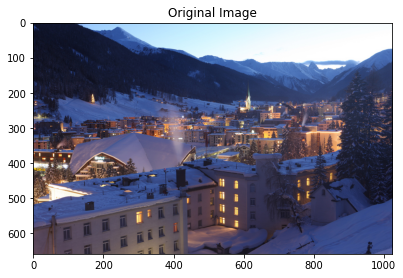

...applying blending


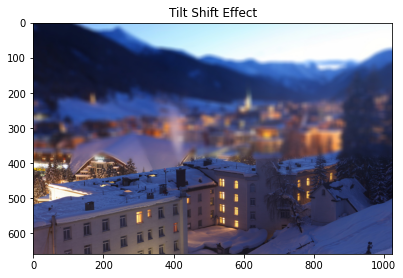

...[DONE]
boat.jpg


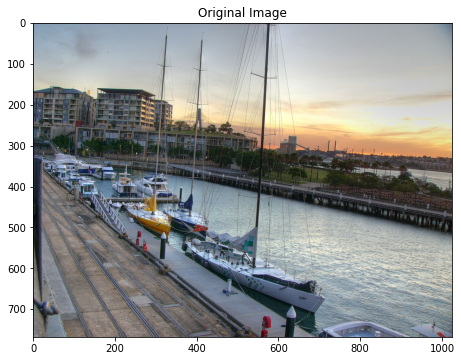

...applying blending


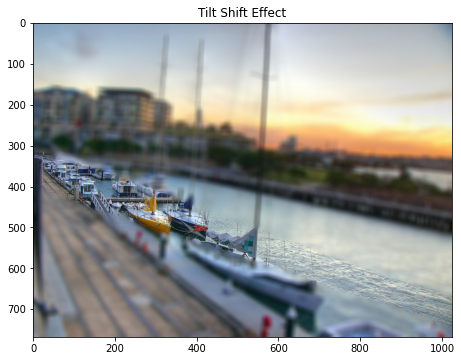

...[DONE]


In [3]:
def main():
    """Given the two images, blend them according to the mask."""

    sourcefolder = 'images/original'
    outfolder = 'images/output'

    if os.path.isdir(outfolder):
        shutil.rmtree(outfolder)
    os.mkdir(outfolder)

    for photo, white_img, black_img, mask_img in get_images(sourcefolder):
        imshow("Original Image", black_img)
        print("...applying blending")
        black_img = black_img.astype(float)
        white_img = white_img.astype(float)
        mask_img = mask_img.astype(float) / 255

        out_layers = []
        for channel in range(3):
            outimg = run_blend(black_img[:, :, channel],
                               white_img[:, :, channel],
                               mask_img[:, :, channel])
            out_layers.append(outimg)

        outimg = cv2.merge(out_layers)
        cv2.imwrite(os.path.join(outfolder, photo), outimg)
        imshow("Tilt Shift Effect", outimg)
        print('...[DONE]')

if __name__ == "__main__":
    main()